# Import

In [1]:

# Import Library
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import models,transforms

from collections import namedtuple

from sklearn.metrics import classification_report

import time

# Get DATA

In [2]:
# Using CUDA
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else: print("Using CPU")

Using CUDA


In [3]:
# Clone Data
!git clone https://github.com/qcuong103/echocardiography

# Hyper-parameters
classes = ['2C', '3C', '4C']
TrainTest = namedtuple('TrainTest', ['train', 'test'])

Cloning into 'echocardiography'...
remote: Enumerating objects: 8335, done.
remote: Total 8335 (delta 0), reused 0 (delta 0), pack-reused 8335
Receiving objects: 100% (8335/8335), 488.10 MiB | 30.96 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (8327/8327), done.


# Prepare Data

In [4]:
# Transforms Data
def prepare_data(sizeImg=224, typeImg="None"):
  if (typeImg == "None"):
    if (sizeImg == 224):
      transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
    elif (sizeImg == 64):
      transform_train = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
    else:
      transform_train = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
  elif (typeImg == "aug"):
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=10),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()])
  else:
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    
  trainset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/train', 
      transform=transform_train)
  testset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  
  print("Number of Image in train set:", len(trainset))
  print("Number of Image in test set:", len(testset))

  return TrainTest(train=trainset,test=testset)

# Load Data
def prepare_loader(datasets):
  batch_size = 32
  trainloader = DataLoader(
    dataset=datasets.train, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  testloader = DataLoader(
    dataset=datasets.test, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  
  print("Num batch in train set: ", len(trainloader))
  print("Num batch in test set: ", len(testloader))
  class_names = datasets.train.classes
  inputs, classes = next(iter(trainloader))
  # show_databatch(inputs, classes)
  for i in range(4):
    print([class_names[x] for x in classes[(8*i):(8*i+8)]])
  imshow(torchvision.utils.make_grid(inputs))
  return TrainTest(train=trainloader, test=testloader)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# dataset = prepare_data()
# loaderset = prepare_loader(dataset)

In [5]:
torch.__version__

'1.10.0+cu111'

# **Train**

In [6]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  print("Train model")
  print('-' * 10)
  model.train()
  running_loss = 0.0
  images_so_close = 0.0
  reporting_steps = 60

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()

    images_so_close = loss.item()
    running_loss += images_so_close
    if i % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  return images_so_close


# **Test**

In [7]:
def test_epoch(epoch, model, loader, device):
  since = time.time()

  model.eval()
  ytrue = []
  ypred = []

  print("Test model")
  print('-' * 10)

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    ytrue += list(labels.cpu().numpy())
    ypred += list(predicted.cpu().numpy())

  elapsed_time = time.time() - since
  print()
  print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
  print('-' * 10)

  return ypred, ytrue

# **Main**

In [8]:
def run(modelName, imgSize, aug):
  PATH = "./" + modelName + '.pth'
  datasets = prepare_data(imgSize, aug)
  loaders = prepare_loader(datasets)
  use_pretrained = False
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("image size: ", datasets.train[0][0].shape)
  print("device:", device)
  print("model:", modelName)
  
  if modelName == 'vgg16':
    model = models.vgg16(pretrained=use_pretrained)
    model.classifier[6] = nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
  elif modelName == 'resnet50':
    model = models.resnet50(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
  elif modelName == 'resnet18':
    model = models.resnet18(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=512, out_features=3, bias=True)
  else:
    model = models.densenet121(pretrained=use_pretrained)
    model.classifier = nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
  model.to(device)

  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  # class_out = len(classes)
  n_epoch = 20

  accuracies = []
  losses = []
  for epoch in range(n_epoch):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    loss = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred, ytrue = test_epoch(epoch, model, loaders.test, device)

    print("Test report: \n", classification_report(ytrue, ypred, target_names=classes))
    
    torch.save(model.state_dict(), PATH)

    ypred = np.array(ypred)
    ytrue = np.array(ytrue)
    accuracy = int((ytrue==ypred).sum() / len(ytrue) * 100)
    accuracies.append(accuracy)
    losses.append(round(loss, 4))

  print("model:", modelName, ", size:", imgSize, ", augmentation:", aug)
  print("accr: ", accuracies)
  print("loss: ", losses)
  return model

# **Run**

Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['3C', '4C', '2C', '2C', '4C', '2C', '2C', '3C']
['3C', '2C', '2C', '4C', '4C', '4C', '4C', '2C']
['3C', '4C', '4C', '3C', '3C', '2C', '4C', '4C']
['3C', '2C', '2C', '3C', '2C', '3C', '2C', '2C']


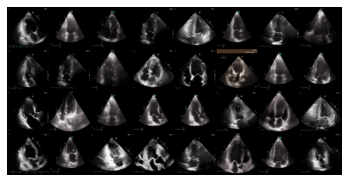

image size:  torch.Size([3, 64, 64])
device: cuda
model: vgg16
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 1.0924
Epoch 0 Step 119 ave_loss 0.9388
Epoch 0 Step 179 ave_loss 0.5268
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.17      0.01      0.01       409
          3C       0.40      0.99      0.57       367
          4C       0.99      0.81      0.89       831

    accuracy                           0.64      1607
   macro avg       0.52      0.60      0.49      1607
weighted avg       0.65      0.64      0.59      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.3323
Epoch 1 Step 119 ave_loss 0.1670
Epoch 1 Step 179 ave_loss 0.1119
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.64      0.92      0.76       409
          3C       0.87      0.93      0.90       367
          4C       1.00      0.76      0.86       831

    accuracy                           0.84      1607
   macro avg       0.84      0.87      0.84      1607
weighted avg       0.88      0.84      0.84      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.0949
Epoch 2 Step 119 ave_loss 0.0748
Epoch 2 Step 179 ave_loss 0.0389
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.65      0.93      0.76       409
          3C       0.84      0.92      0.88       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.83      1607
   macro avg       0.83      0.86      0.83      1607
weighted avg       0.87      0.83      0.84      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.0104
Epoch 3 Step 119 ave_loss 0.0169
Epoch 3 Step 179 ave_loss 0.0086
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.80      0.97      0.88       409
          3C       0.95      0.89      0.92       367
          4C       1.00      0.92      0.96       831

    accuracy                           0.93      1607
   macro avg       0.92      0.93      0.92      1607
weighted avg       0.94      0.93      0.93      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0002
Epoch 4 Step 119 ave_loss 0.0001
Epoch 4 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.80      0.94      0.87       409
          3C       0.86      0.95      0.90       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0001
Epoch 5 Step 119 ave_loss 0.0000
Epoch 5 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.94      0.86       409
          3C       0.86      0.94      0.90       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0000
Epoch 6 Step 119 ave_loss 0.0000
Epoch 6 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.94      0.86       409
          3C       0.87      0.94      0.90       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0000
Epoch 7 Step 119 ave_loss 0.0000
Epoch 7 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.94      0.86       409
          3C       0.87      0.93      0.90       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.90      0.90      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0000
Epoch 8 Step 119 ave_loss 0.0001
Epoch 8 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.94      0.85       409
          3C       0.87      0.93      0.90       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.88      0.91      0.89      1607
weighted avg       0.92      0.90      0.90      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0000
Epoch 9 Step 119 ave_loss 0.0000
Epoch 9 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.94      0.85       409
          3C       0.88      0.93      0.90       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.90      0.90      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0000
Epoch 10 Step 119 ave_loss 0.0001
Epoch 10 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0001
Epoch 11 Step 119 ave_loss 0.0001
Epoch 11 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0001
Epoch 12 Step 119 ave_loss 0.0001
Epoch 12 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0001
Epoch 13 Step 119 ave_loss 0.0001
Epoch 13 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.84       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.90      0.90      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0001
Epoch 14 Step 119 ave_loss 0.0001
Epoch 14 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.90      0.91      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0001
Epoch 15 Step 119 ave_loss 0.0001
Epoch 15 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.90      0.93      0.91       367
          4C       1.00      0.88      0.94       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0001
Epoch 16 Step 119 ave_loss 0.0001
Epoch 16 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.90      0.93      0.91       367
          4C       1.00      0.88      0.94       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0001
Epoch 17 Step 119 ave_loss 0.0001
Epoch 17 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.84       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.89      1607
weighted avg       0.92      0.90      0.90      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0001
Epoch 18 Step 119 ave_loss 0.0001
Epoch 18 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.94      0.85       409
          3C       0.90      0.93      0.91       367
          4C       1.00      0.88      0.94       831

    accuracy                           0.91      1607
   macro avg       0.89      0.92      0.90      1607
weighted avg       0.92      0.91      0.91      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0001
Epoch 19 Step 119 ave_loss 0.0001
Epoch 19 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.77      0.94      0.85       409
          3C       0.89      0.93      0.91       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.90      0.91      1607

model: vgg16 , size: 64 , augmentation: None
accr:  [64, 83, 83, 92, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
loss:  [0.6319, 0.0064, 0.0054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0003, 0.0001, 0.0001, 0.0, 0.0, 0.0001, 0.0, 0.0]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['2C', '2C', '4C', '4C', '4C', '4C', '2C', '3C']
['4C', '2C', '2C', '2C', '4C', '3C', '2C', '3C']
['4C', '4C', '4C', '2C', '2C', '3C', '2C', '4C']
['2C', '2C', '2C', '2C', '3C', '2C', '4C', '2C']


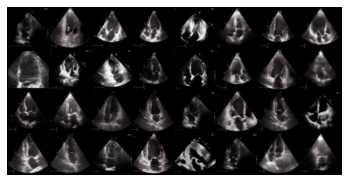

image size:  torch.Size([3, 64, 64])
device: cuda
model: resnet18
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 0.4084
Epoch 0 Step 119 ave_loss 0.0730
Epoch 0 Step 179 ave_loss 0.0336
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.97      0.86       409
          3C       0.99      0.83      0.90       367
          4C       0.98      0.93      0.96       831

    accuracy                           0.92      1607
   macro avg       0.92      0.91      0.91      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.0072
Epoch 1 Step 119 ave_loss 0.0009
Epoch 1 Step 179 ave_loss 0.0049
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.91      0.78      0.84       409
          3C       0.85      0.93      0.89       367
          4C       0.95      0.98      0.97       831

    accuracy                           0.92      1607
   macro avg       0.91      0.90      0.90      1607
weighted avg       0.92      0.92      0.92      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.0009
Epoch 2 Step 119 ave_loss 0.0014
Epoch 2 Step 179 ave_loss 0.0060
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.87      0.98      0.92       409
          3C       0.94      0.89      0.91       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.95      1607
   macro avg       0.94      0.94      0.94      1607
weighted avg       0.95      0.95      0.95      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.0209
Epoch 3 Step 119 ave_loss 0.0170
Epoch 3 Step 179 ave_loss 0.0008
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.97      0.90       409
          3C       0.87      0.93      0.90       367
          4C       1.00      0.89      0.94       831

    accuracy                           0.92      1607
   macro avg       0.90      0.93      0.91      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0015
Epoch 4 Step 119 ave_loss 0.0004
Epoch 4 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.78      0.97      0.86       409
          3C       0.87      0.90      0.88       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.90      1607
   macro avg       0.88      0.91      0.89      1607
weighted avg       0.91      0.90      0.90      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0001
Epoch 5 Step 119 ave_loss 0.0002
Epoch 5 Step 179 ave_loss 0.0009
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.92      0.95      0.94       409
          3C       0.87      0.92      0.89       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.95      1607
   macro avg       0.93      0.94      0.94      1607
weighted avg       0.95      0.95      0.95      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0002
Epoch 6 Step 119 ave_loss 0.0001
Epoch 6 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.90      0.96      0.93       409
          3C       0.88      0.90      0.89       367
          4C       1.00      0.95      0.98       831

    accuracy                           0.95      1607
   macro avg       0.93      0.94      0.93      1607
weighted avg       0.95      0.95      0.95      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0001
Epoch 7 Step 119 ave_loss 0.0001
Epoch 7 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.96      0.93       409
          3C       0.91      0.90      0.90       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.95      1607
   macro avg       0.93      0.94      0.94      1607
weighted avg       0.95      0.95      0.95      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0000
Epoch 8 Step 119 ave_loss 0.0001
Epoch 8 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.95      0.92       409
          3C       0.87      0.91      0.89       367
          4C       1.00      0.95      0.97       831

    accuracy                           0.94      1607
   macro avg       0.92      0.94      0.93      1607
weighted avg       0.94      0.94      0.94      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0001
Epoch 9 Step 119 ave_loss 0.0000
Epoch 9 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.96      0.92       409
          3C       0.87      0.91      0.89       367
          4C       1.00      0.94      0.97       831

    accuracy                           0.94      1607
   macro avg       0.92      0.94      0.93      1607
weighted avg       0.94      0.94      0.94      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0001
Epoch 10 Step 119 ave_loss 0.0002
Epoch 10 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.92      0.94      0.93       409
          3C       0.87      0.93      0.90       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.95      1607
   macro avg       0.93      0.94      0.94      1607
weighted avg       0.95      0.95      0.95      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0000
Epoch 11 Step 119 ave_loss 0.0001
Epoch 11 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.93      0.95      0.94       409
          3C       0.90      0.93      0.92       367
          4C       1.00      0.97      0.99       831

    accuracy                           0.96      1607
   macro avg       0.94      0.95      0.95      1607
weighted avg       0.96      0.96      0.96      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0000
Epoch 12 Step 119 ave_loss 0.0000
Epoch 12 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.90      0.95      0.93       409
          3C       0.88      0.93      0.90       367
          4C       1.00      0.94      0.97       831

    accuracy                           0.94      1607
   macro avg       0.93      0.94      0.93      1607
weighted avg       0.95      0.94      0.94      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0000
Epoch 13 Step 119 ave_loss 0.0000
Epoch 13 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.92      0.95      0.94       409
          3C       0.91      0.93      0.92       367
          4C       1.00      0.97      0.99       831

    accuracy                           0.96      1607
   macro avg       0.94      0.95      0.95      1607
weighted avg       0.96      0.96      0.96      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0001
Epoch 14 Step 119 ave_loss 0.0001
Epoch 14 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.92      0.95      0.94       409
          3C       0.88      0.94      0.91       367
          4C       1.00      0.95      0.98       831

    accuracy                           0.95      1607
   macro avg       0.93      0.95      0.94      1607
weighted avg       0.95      0.95      0.95      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0000
Epoch 15 Step 119 ave_loss 0.0001
Epoch 15 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.93      0.96      0.94       409
          3C       0.92      0.93      0.93       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.96      1607
   macro avg       0.95      0.96      0.95      1607
weighted avg       0.96      0.96      0.96      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0001
Epoch 16 Step 119 ave_loss 0.0001
Epoch 16 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.94      0.96      0.95       409
          3C       0.91      0.94      0.92       367
          4C       1.00      0.97      0.99       831

    accuracy                           0.96      1607
   macro avg       0.95      0.96      0.95      1607
weighted avg       0.96      0.96      0.96      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0001
Epoch 17 Step 119 ave_loss 0.0000
Epoch 17 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.90      0.96      0.93       409
          3C       0.92      0.92      0.92       367
          4C       1.00      0.96      0.98       831

    accuracy                           0.95      1607
   macro avg       0.94      0.95      0.94      1607
weighted avg       0.96      0.95      0.95      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0001
Epoch 18 Step 119 ave_loss 0.0000
Epoch 18 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.94      0.96      0.95       409
          3C       0.91      0.94      0.92       367
          4C       1.00      0.98      0.99       831

    accuracy                           0.96      1607
   macro avg       0.95      0.96      0.95      1607
weighted avg       0.96      0.96      0.96      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0001
Epoch 19 Step 119 ave_loss 0.0001
Epoch 19 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.96      0.93       409
          3C       0.90      0.93      0.92       367
          4C       1.00      0.95      0.97       831

    accuracy                           0.95      1607
   macro avg       0.93      0.95      0.94      1607
weighted avg       0.95      0.95      0.95      1607

model: resnet18 , size: 64 , augmentation: None
accr:  [91, 91, 95, 91, 89, 94, 94, 94, 93, 94, 94, 95, 94, 95, 94, 96, 96, 95, 96, 94]
loss:  [0.001, 0.0019, 0.0, 0.0, 0.0001, 0.0005, 0.0, 0.0, 0.0002, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['4C', '3C', '2C', '3C', '3C', '3C', '2C', '3C']
['2C', '2C', '3C', '3C', '3C', '3C', '4C', '4C']
['3C', '2C', '3C', '3C', '2C', '3C', '4C', '3C']
['4C', '4C', '4C', '2C', '4C', '3C', '4C', '4C']


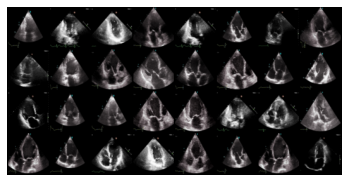

image size:  torch.Size([3, 64, 64])
device: cuda
model: resnet50
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 4.0800
Epoch 0 Step 119 ave_loss 2.5886
Epoch 0 Step 179 ave_loss 1.3824
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.36      0.73      0.48       409
          3C       0.47      0.37      0.41       367
          4C       0.87      0.51      0.64       831

    accuracy                           0.53      1607
   macro avg       0.57      0.53      0.51      1607
weighted avg       0.65      0.53      0.55      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.7414
Epoch 1 Step 119 ave_loss 0.5124
Epoch 1 Step 179 ave_loss 0.7551
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.48      0.88      0.62       409
          3C       0.79      0.58      0.67       367
          4C       0.99      0.70      0.82       831

    accuracy                           0.72      1607
   macro avg       0.75      0.72      0.70      1607
weighted avg       0.81      0.72      0.74      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.2345
Epoch 2 Step 119 ave_loss 0.2458
Epoch 2 Step 179 ave_loss 0.2175
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.73      0.48      0.58       409
          3C       0.51      0.87      0.64       367
          4C       0.97      0.83      0.89       831

    accuracy                           0.75      1607
   macro avg       0.74      0.73      0.70      1607
weighted avg       0.80      0.75      0.76      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.1755
Epoch 3 Step 119 ave_loss 0.1179
Epoch 3 Step 179 ave_loss 0.1033
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.58      0.86      0.69       409
          3C       0.72      0.74      0.73       367
          4C       0.98      0.74      0.84       831

    accuracy                           0.77      1607
   macro avg       0.76      0.78      0.75      1607
weighted avg       0.82      0.77      0.78      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0482
Epoch 4 Step 119 ave_loss 0.0248
Epoch 4 Step 179 ave_loss 0.0545
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.82      0.75       409
          3C       0.79      0.83      0.81       367
          4C       0.99      0.89      0.94       831

    accuracy                           0.86      1607
   macro avg       0.83      0.84      0.83      1607
weighted avg       0.87      0.86      0.86      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0129
Epoch 5 Step 119 ave_loss 0.0278
Epoch 5 Step 179 ave_loss 0.0732
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.81      0.75       409
          3C       0.68      0.80      0.73       367
          4C       1.00      0.84      0.91       831

    accuracy                           0.82      1607
   macro avg       0.79      0.82      0.80      1607
weighted avg       0.85      0.82      0.83      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0317
Epoch 6 Step 119 ave_loss 0.0294
Epoch 6 Step 179 ave_loss 0.0215
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.75      0.81      0.78       409
          3C       0.73      0.85      0.79       367
          4C       1.00      0.89      0.94       831

    accuracy                           0.86      1607
   macro avg       0.83      0.85      0.84      1607
weighted avg       0.88      0.86      0.86      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0121
Epoch 7 Step 119 ave_loss 0.0122
Epoch 7 Step 179 ave_loss 0.0021
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.56      0.84      0.67       409
          3C       0.68      0.69      0.69       367
          4C       0.98      0.74      0.84       831

    accuracy                           0.75      1607
   macro avg       0.74      0.76      0.73      1607
weighted avg       0.81      0.75      0.76      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0018
Epoch 8 Step 119 ave_loss 0.0297
Epoch 8 Step 179 ave_loss 0.0057
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.48      0.77      0.59       409
          3C       0.65      0.83      0.73       367
          4C       1.00      0.58      0.73       831

    accuracy                           0.68      1607
   macro avg       0.71      0.73      0.68      1607
weighted avg       0.79      0.68      0.69      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0062
Epoch 9 Step 119 ave_loss 0.0013
Epoch 9 Step 179 ave_loss 0.0019
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.73      0.92      0.82       409
          3C       0.83      0.78      0.81       367
          4C       0.99      0.89      0.94       831

    accuracy                           0.87      1607
   macro avg       0.85      0.87      0.85      1607
weighted avg       0.89      0.87      0.88      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0022
Epoch 10 Step 119 ave_loss 0.0016
Epoch 10 Step 179 ave_loss 0.0003
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.85      0.77       409
          3C       0.71      0.84      0.77       367
          4C       1.00      0.81      0.90       831

    accuracy                           0.83      1607
   macro avg       0.80      0.84      0.81      1607
weighted avg       0.86      0.83      0.84      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0006
Epoch 11 Step 119 ave_loss 0.0069
Epoch 11 Step 179 ave_loss 0.0065
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.63      0.93      0.75       409
          3C       0.84      0.74      0.79       367
          4C       0.99      0.82      0.90       831

    accuracy                           0.83      1607
   macro avg       0.82      0.83      0.81      1607
weighted avg       0.87      0.83      0.83      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0067
Epoch 12 Step 119 ave_loss 0.0006
Epoch 12 Step 179 ave_loss 0.0037
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.62      0.82      0.71       409
          3C       0.75      0.70      0.72       367
          4C       0.99      0.86      0.92       831

    accuracy                           0.81      1607
   macro avg       0.79      0.79      0.78      1607
weighted avg       0.84      0.81      0.82      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0023
Epoch 13 Step 119 ave_loss 0.0010
Epoch 13 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.64      0.82      0.72       409
          3C       0.75      0.73      0.74       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.83      1607
   macro avg       0.80      0.81      0.80      1607
weighted avg       0.85      0.83      0.83      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0007
Epoch 14 Step 119 ave_loss 0.0002
Epoch 14 Step 179 ave_loss 0.0009
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.66      0.81      0.73       409
          3C       0.75      0.77      0.76       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.83      1607
   macro avg       0.80      0.82      0.81      1607
weighted avg       0.85      0.83      0.84      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0012
Epoch 15 Step 119 ave_loss 0.0044
Epoch 15 Step 179 ave_loss 0.0004
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.62      0.83      0.71       409
          3C       0.77      0.76      0.77       367
          4C       1.00      0.84      0.91       831

    accuracy                           0.82      1607
   macro avg       0.80      0.81      0.80      1607
weighted avg       0.85      0.82      0.83      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0006
Epoch 16 Step 119 ave_loss 0.0001
Epoch 16 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.82      0.75       409
          3C       0.76      0.84      0.80       367
          4C       1.00      0.86      0.93       831

    accuracy                           0.85      1607
   macro avg       0.82      0.84      0.83      1607
weighted avg       0.87      0.85      0.85      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0001
Epoch 17 Step 119 ave_loss 0.0001
Epoch 17 Step 179 ave_loss 0.0000
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.70      0.81      0.75       409
          3C       0.75      0.84      0.79       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.85      1607
   macro avg       0.82      0.84      0.82      1607
weighted avg       0.87      0.85      0.85      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0000
Epoch 18 Step 119 ave_loss 0.0009
Epoch 18 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 12s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.67      0.81      0.74       409
          3C       0.75      0.83      0.79       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.84      1607
   macro avg       0.81      0.83      0.81      1607
weighted avg       0.86      0.84      0.84      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0001
Epoch 19 Step 119 ave_loss 0.0115
Epoch 19 Step 179 ave_loss 0.0012
Test model
----------

Evaluation completed in 0m 13s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.76      0.78      0.77       409
          3C       0.72      0.80      0.76       367
          4C       0.99      0.93      0.96       831

    accuracy                           0.86      1607
   macro avg       0.83      0.84      0.83      1607
weighted avg       0.87      0.86      0.87      1607

model: resnet50 , size: 64 , augmentation: None
accr:  [53, 71, 74, 76, 85, 82, 85, 75, 68, 87, 82, 82, 81, 82, 83, 81, 84, 84, 83, 86]
loss:  [0.6727, 0.3752, 0.148, 0.3335, 0.0922, 0.0024, 0.0004, 0.0007, 0.0097, 0.0153, 0.0, 0.0001, 0.0, 0.0215, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['3C', '3C', '4C', '4C', '3C', '3C', '4C', '3C']
['4C', '4C', '2C', '2C', '2C', '2C', '3C', '4C']
['3C', '2C', '4C', '3C', '2C', '4C', '2C', '2C']
['4C', '2C', '3C', '3C', '3C', '3C', '3C', '2C']


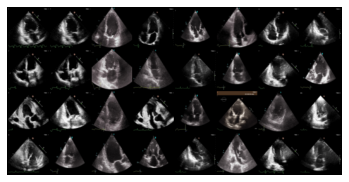

image size:  torch.Size([3, 64, 64])
device: cuda
model: densenet121
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 0.5646
Epoch 0 Step 119 ave_loss 0.1462
Epoch 0 Step 179 ave_loss 0.0315
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.58      0.75      0.65       409
          3C       0.57      0.90      0.70       367
          4C       1.00      0.60      0.75       831

    accuracy                           0.71      1607
   macro avg       0.72      0.75      0.70      1607
weighted avg       0.79      0.71      0.71      1607

---------------------------------------------------------------

Epoch 1 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Step 59 ave_loss 0.0202
Epoch 1 Step 119 ave_loss 0.0162
Epoch 1 Step 179 ave_loss 0.0033
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.94      0.88       409
          3C       0.87      0.85      0.86       367
          4C       1.00      0.94      0.97       831

    accuracy                           0.92      1607
   macro avg       0.90      0.91      0.90      1607
weighted avg       0.93      0.92      0.92      1607

---------------------------------------------------------------

Epoch 2 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Step 59 ave_loss 0.0088
Epoch 2 Step 119 ave_loss 0.0018
Epoch 2 Step 179 ave_loss 0.0051
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.76      0.77       409
          3C       0.60      0.94      0.73       367
          4C       1.00      0.77      0.87       831

    accuracy                           0.80      1607
   macro avg       0.80      0.82      0.79      1607
weighted avg       0.85      0.80      0.81      1607

---------------------------------------------------------------

Epoch 3 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Step 59 ave_loss 0.0023
Epoch 3 Step 119 ave_loss 0.0004
Epoch 3 Step 179 ave_loss 0.0007
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.81      0.78      0.80       409
          3C       0.63      0.89      0.74       367
          4C       1.00      0.83      0.91       831

    accuracy                           0.83      1607
   macro avg       0.81      0.83      0.81      1607
weighted avg       0.87      0.83      0.84      1607

---------------------------------------------------------------

Epoch 4 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Step 59 ave_loss 0.0019
Epoch 4 Step 119 ave_loss 0.0005
Epoch 4 Step 179 ave_loss 0.0007
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.73      0.80       409
          3C       0.65      0.94      0.77       367
          4C       1.00      0.89      0.94       831

    accuracy                           0.86      1607
   macro avg       0.85      0.85      0.84      1607
weighted avg       0.89      0.86      0.87      1607

---------------------------------------------------------------

Epoch 5 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Step 59 ave_loss 0.0004
Epoch 5 Step 119 ave_loss 0.0003
Epoch 5 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.83      0.82       409
          3C       0.70      0.92      0.80       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.86      1607
   macro avg       0.84      0.87      0.85      1607
weighted avg       0.89      0.86      0.87      1607

---------------------------------------------------------------

Epoch 6 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Step 59 ave_loss 0.0002
Epoch 6 Step 119 ave_loss 0.0003
Epoch 6 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 10s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.79      0.84      0.81       409
          3C       0.71      0.91      0.80       367
          4C       1.00      0.84      0.92       831

    accuracy                           0.86      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.88      0.86      0.86      1607

---------------------------------------------------------------

Epoch 7 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Step 59 ave_loss 0.0012
Epoch 7 Step 119 ave_loss 0.0052
Epoch 7 Step 179 ave_loss 0.0062
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.82      0.83       409
          3C       0.73      0.81      0.76       367
          4C       0.98      0.94      0.96       831

    accuracy                           0.88      1607
   macro avg       0.85      0.86      0.85      1607
weighted avg       0.89      0.88      0.88      1607

---------------------------------------------------------------

Epoch 8 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Step 59 ave_loss 0.0029
Epoch 8 Step 119 ave_loss 0.0016
Epoch 8 Step 179 ave_loss 0.0166
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.75      0.79       409
          3C       0.57      0.81      0.67       367
          4C       0.98      0.85      0.91       831

    accuracy                           0.82      1607
   macro avg       0.80      0.80      0.79      1607
weighted avg       0.85      0.82      0.83      1607

---------------------------------------------------------------

Epoch 9 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Step 59 ave_loss 0.0008
Epoch 9 Step 119 ave_loss 0.0003
Epoch 9 Step 179 ave_loss 0.0005
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.67      0.74      0.70       409
          3C       0.61      0.89      0.73       367
          4C       1.00      0.75      0.86       831

    accuracy                           0.78      1607
   macro avg       0.76      0.79      0.76      1607
weighted avg       0.83      0.78      0.79      1607

---------------------------------------------------------------

Epoch 10 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Step 59 ave_loss 0.0012
Epoch 10 Step 119 ave_loss 0.0014
Epoch 10 Step 179 ave_loss 0.0004
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.87      0.92      0.89       409
          3C       0.67      0.87      0.76       367
          4C       1.00      0.84      0.91       831

    accuracy                           0.87      1607
   macro avg       0.85      0.88      0.85      1607
weighted avg       0.89      0.87      0.87      1607

---------------------------------------------------------------

Epoch 11 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Step 59 ave_loss 0.0002
Epoch 11 Step 119 ave_loss 0.0002
Epoch 11 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.85      0.85      0.85       409
          3C       0.63      0.90      0.74       367
          4C       1.00      0.80      0.89       831

    accuracy                           0.84      1607
   macro avg       0.83      0.85      0.83      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 12 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Step 59 ave_loss 0.0007
Epoch 12 Step 119 ave_loss 0.0004
Epoch 12 Step 179 ave_loss 0.0003
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.91      0.90       409
          3C       0.72      0.95      0.82       367
          4C       1.00      0.84      0.92       831

    accuracy                           0.89      1607
   macro avg       0.87      0.90      0.88      1607
weighted avg       0.91      0.89      0.89      1607

---------------------------------------------------------------

Epoch 13 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Step 59 ave_loss 0.0002
Epoch 13 Step 119 ave_loss 0.0002
Epoch 13 Step 179 ave_loss 0.0001
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.89      0.89       409
          3C       0.68      0.94      0.79       367
          4C       1.00      0.83      0.91       831

    accuracy                           0.87      1607
   macro avg       0.86      0.89      0.86      1607
weighted avg       0.90      0.87      0.88      1607

---------------------------------------------------------------

Epoch 14 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Step 59 ave_loss 0.0002
Epoch 14 Step 119 ave_loss 0.0002
Epoch 14 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.84      0.91      0.88       409
          3C       0.66      0.90      0.76       367
          4C       1.00      0.80      0.89       831

    accuracy                           0.85      1607
   macro avg       0.84      0.87      0.84      1607
weighted avg       0.88      0.85      0.86      1607

---------------------------------------------------------------

Epoch 15 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Step 59 ave_loss 0.0002
Epoch 15 Step 119 ave_loss 0.0001
Epoch 15 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.95      0.83      0.89       409
          3C       0.66      0.99      0.79       367
          4C       1.00      0.84      0.91       831

    accuracy                           0.87      1607
   macro avg       0.87      0.89      0.86      1607
weighted avg       0.91      0.87      0.88      1607

---------------------------------------------------------------

Epoch 16 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Step 59 ave_loss 0.0002
Epoch 16 Step 119 ave_loss 0.0001
Epoch 16 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.89      0.90      0.89       409
          3C       0.68      0.95      0.79       367
          4C       1.00      0.82      0.90       831

    accuracy                           0.87      1607
   macro avg       0.86      0.89      0.86      1607
weighted avg       0.90      0.87      0.87      1607

---------------------------------------------------------------

Epoch 17 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Step 59 ave_loss 0.0001
Epoch 17 Step 119 ave_loss 0.0001
Epoch 17 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.83      0.89      0.86       409
          3C       0.66      0.92      0.77       367
          4C       1.00      0.79      0.88       831

    accuracy                           0.84      1607
   macro avg       0.83      0.87      0.84      1607
weighted avg       0.88      0.84      0.85      1607

---------------------------------------------------------------

Epoch 18 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Step 59 ave_loss 0.0001
Epoch 18 Step 119 ave_loss 0.0003
Epoch 18 Step 179 ave_loss 0.0002
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.82      0.86      0.84       409
          3C       0.64      0.91      0.75       367
          4C       1.00      0.78      0.88       831

    accuracy                           0.83      1607
   macro avg       0.82      0.85      0.82      1607
weighted avg       0.87      0.83      0.84      1607

---------------------------------------------------------------

Epoch 19 report: 
Train model
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Step 59 ave_loss 0.0002
Epoch 19 Step 119 ave_loss 0.0005
Epoch 19 Step 179 ave_loss 0.0014
Test model
----------

Evaluation completed in 0m 11s
----------
Test report: 
               precision    recall  f1-score   support

          2C       0.81      0.85      0.83       409
          3C       0.66      0.95      0.78       367
          4C       1.00      0.78      0.88       831

    accuracy                           0.84      1607
   macro avg       0.82      0.86      0.83      1607
weighted avg       0.87      0.84      0.84      1607

model: densenet121 , size: 64 , augmentation: None
accr:  [70, 92, 80, 83, 85, 86, 85, 87, 81, 77, 86, 83, 88, 87, 85, 87, 86, 84, 83, 83]
loss:  [0.0896, 0.0369, 0.0012, 0.0005, 0.0004, 0.0001, 0.0001, 0.0883, 0.0114, 0.0001, 0.003, 0.0001, 0.0001, 0.0001, 0.0004, 0.0001, 0.0, 0.0001, 0.0001, 0.0001]


In [9]:
modelset = ['vgg16', 'resnet18', 'resnet50', 'densenet121']

for i in modelset:
  model = run(modelName=i, imgSize=64, aug="None")

# Demo mô hình với video

In [16]:
def run_video(modelName = 'vgg16'):
  print(modelName)
  transform_test = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  videotest = namedtuple('videotest', ['id', "ytrues", 'ypreds'])
  id_video = []

  for i, image in enumerate(sample_data.imgs):
    id_video.append(image[0].split("/")[-1].split("_")[0])
  
  video_list = []
  for image in id_video:
    if (image in video_list) == False:
      video_list.append(image)
    else:
      pass

  ytrue = []
  ypred = []

  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'), strict=False)
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet18(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'), strict=False)
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'), strict=False)

  modelload.to('cuda')
  modelload.eval()
  for image, label in sample_data:
    image = image.unsqueeze(0).to('cuda')
    output = modelload(image)
    _, predicted = torch.max(output, dim=1)
    ytrue.append(label)
    ypred += list(predicted.cpu().numpy())

  outputs_video = []
  ytrue_video = []
  ypred_video = []
  index = 0
  for id in video_list:
    index += 1
    vtrue = []
    vpred = []
    for i, img in enumerate(id_video):
      if img == id:
        vtrue.append(ytrue[i])
        vpred.append(ypred[i])

    rate_true = [0, 0, 0]
    rate_pred = [0, 0, 0]
    for label in range(3):
      rate_true[label] = list(vtrue).count(label)
      rate_pred[label] = list(vpred).count(label)

    labeltrue = np.argmax(rate_true)
    labelpred = np.argmax(rate_pred)

    if index %4 != 0:
      print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred, end="  |  ")
    else: print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred)
    ytrue_video.append(labeltrue)
    ypred_video.append(labelpred)
    outputs_video.append(videotest(id=id,ytrues=labeltrue,ypreds=labelpred))
  print(classification_report(ytrue_video, ypred_video, target_names=classes))
  return outputs_video

In [17]:
# result = run_video('vgg16')
for i in modelset:
  result = run_video(modelName=i)

vgg16
id:  158 , true: 0 , pred:  0  |  id:  165 , true: 0 , pred:  0  |  id:  168 , true: 0 , pred:  0  |  id:  169 , true: 0 , pred:  1
id:  171 , true: 0 , pred:  0  |  id:  176 , true: 0 , pred:  0  |  id:  177 , true: 0 , pred:  0  |  id:  178 , true: 0 , pred:  0
id:  181 , true: 0 , pred:  0  |  id:  183 , true: 0 , pred:  0  |  id:  191 , true: 0 , pred:  0  |  id:  192 , true: 0 , pred:  0
id:  157 , true: 1 , pred:  1  |  id:  159 , true: 1 , pred:  1  |  id:  161 , true: 1 , pred:  1  |  id:  162 , true: 1 , pred:  1
id:  166 , true: 1 , pred:  1  |  id:  174 , true: 1 , pred:  1  |  id:  175 , true: 1 , pred:  1  |  id:  179 , true: 1 , pred:  0
id:  185 , true: 1 , pred:  1  |  id:  186 , true: 1 , pred:  1  |  id:  189 , true: 1 , pred:  1  |  id:  190 , true: 1 , pred:  1
id:  194 , true: 1 , pred:  1  |  id:  160 , true: 2 , pred:  0  |  id:  163 , true: 2 , pred:  2  |  id:  164 , true: 2 , pred:  2
id:  167 , true: 2 , pred:  2  |  id:  170 , true: 2 , pred:  2  |  id

In [ ]:
# for i in range(len(result)):
#   if (i+1)%3!=0:
#     print(result[i], end="  |  ")
#   else: print(result[i])

In [20]:
import pandas as pd
def demo_frame(modelName='vgg16'):
  print(modelName)
  transform_test = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  filename = []
  for i, image in enumerate(sample_data.imgs):
    filename.append(image[0].split("/")[-1])
    # print(image[0].split("/")[-1])
  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'), strict=False)
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet18(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=3, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'), strict=False)
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'), strict=False)

  modelload.to('cuda')
  modelload.eval()
  ypred = []
  for image, label in sample_data:
      image = image.unsqueeze(0).to('cuda')
      output = modelload(image)
      _, predicted = torch.max(output, dim=1)
      ypred += list(predicted.cpu().numpy())
  classes0 = {'2C':0 , '3C':1, '4C':2}
  classes0 = dict((v,k) for k,v in classes0.items())
  predictions = [classes0[k] for k in ypred]
  result0 = pd.DataFrame({"Filename":filename, "Prediction":predictions})
  results_file = "./" + modelName + "_results.csv"
  result0.to_csv(results_file,index=False)

In [21]:
for i in modelset:
  result = demo_frame(modelName=i)

vgg16
resnet18
resnet50
densenet121
